## Mapping Transit Network

In [1]:
#Load Packages:

import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import osmnx as ox
import shapely
from shapely.geometry import Point
import folium
from folium import Choropleth

### Load and Inspect GTFS data for Philadelphia:

We utilized the General Transit Feed Specification (GTFS), a standardized data format that provides public transportation schedules and associated network information, to extract SEPTA bus stop locations and stop times at each stop. We simultaneously, also import the bus network for the region and clip it to Philadelphia Metropolitan Area city limits for our analysis.

In [2]:
#Load GTFS Data:

gtfs_folder = "Data/google_bus_Fall 2023"

# Dictionary to store dataframes for each GTFS file
gtfs_dataframes = {}

# Loop through all files in the folder
for file_name in os.listdir(gtfs_folder):
    # Check if the file is a .txt file
    if file_name.endswith(".txt"):
        file_path = os.path.join(gtfs_folder, file_name)
        try:
            # Read the .txt file into a Pandas DataFrame
            dataframe_name = file_name.replace(".txt", "")
            gtfs_dataframes[dataframe_name] = pd.read_csv(file_path)
            print(f"Imported {file_name} as '{dataframe_name}' with {len(gtfs_dataframes[dataframe_name])} rows.")
        except Exception as e:
            print(f"Failed to load {file_name}: {e}")

print(f"Loaded DataFrames: {list(gtfs_dataframes.keys())}")

Imported agency.txt as 'agency' with 1 rows.
Imported calendar.txt as 'calendar' with 21 rows.
Imported calendar_dates.txt as 'calendar_dates' with 140 rows.
Imported fare_attributes.txt as 'fare_attributes' with 10 rows.
Imported fare_rules.txt as 'fare_rules' with 15 rows.
Imported routes.txt as 'routes' with 167 rows.
Imported shapes.txt as 'shapes' with 536093 rows.
Imported stops.txt as 'stops' with 13801 rows.
Imported stop_times.txt as 'stop_times' with 2975534 rows.
Imported transfers.txt as 'transfers' with 8 rows.
Imported trips.txt as 'trips' with 49558 rows.
Loaded DataFrames: ['agency', 'calendar', 'calendar_dates', 'fare_attributes', 'fare_rules', 'routes', 'shapes', 'stops', 'stop_times', 'transfers', 'trips']


In [3]:
# Extract relevant files as dataframes

stops_df = gtfs_dataframes.get("stops", None)
stop_times_df = gtfs_dataframes.get("stop_times", None)
routes_df = gtfs_dataframes.get("routes", None)
shapes_df = gtfs_dataframes.get("shapes", None)


In [4]:
stops_df.head()

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station,zone_id,wheelchair_boarding
0,2,Ridge Av & Wissahickon Transfer Center,40.014986,-75.206826,NaN,31032.0,1,1
1,4,Roosevelt Blvd & Broad St - FS,40.018128,-75.148887,NaN,NaN,1,1
2,5,Roosevelt Blvd & 5th St,40.023465,-75.133487,NaN,NaN,1,1
3,7,Roosevelt Blvd & Pratt St,40.028754,-75.089524,NaN,NaN,1,1
4,8,Roosevelt Blvd & Cottman Av - FS,40.044610,-75.053657,NaN,NaN,1,1


## Create Philadelphia's Bus Network:

Convert all shapes from points to linestrings:

In [5]:
print(shapes_df)

        shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence
0         286406     39.976568    -75.196097                206
1         286406     40.006143    -75.196839                417
2         286406     40.006429    -75.197471                420
3         286410     39.985246    -75.208209                294
4         286410     39.986857    -75.207831                307
...          ...           ...           ...                ...
536088    286742     39.945364    -75.326472                440
536089    286753     39.918701    -75.264710                178
536090    286659     39.949104    -75.275955                152
536091    286660     39.960680    -75.349991                142
536092    286661     39.950913    -75.267558                125

[536093 rows x 4 columns]


<Axes: >

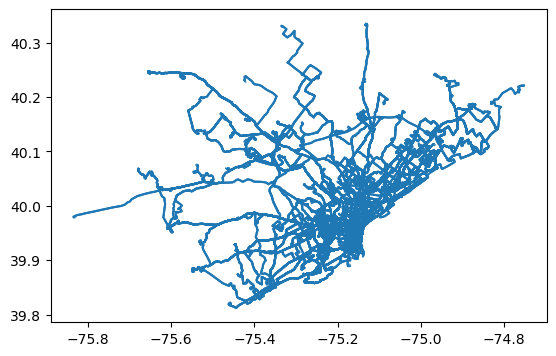

In [6]:
from shapely.geometry import LineString

# Ensure the DataFrame is sorted by shape_id and shape_pt_sequence
shapes_df = shapes_df.sort_values(by=['shape_id', 'shape_pt_sequence'])

# Group by shape_id and create LineString for each group
lines = (
    shapes_df.groupby('shape_id')
    .apply(lambda group: LineString(zip(group['shape_pt_lon'], group['shape_pt_lat'])))
    .reset_index(name='geometry')
)

# Create a GeoDataFrame from the lines
bus_network = gpd.GeoDataFrame(lines, geometry='geometry', crs='EPSG:4326')

bus_network.plot()

### Trim Bus Network to Philadelphia City Boundary



Add city boundary:

<Axes: >

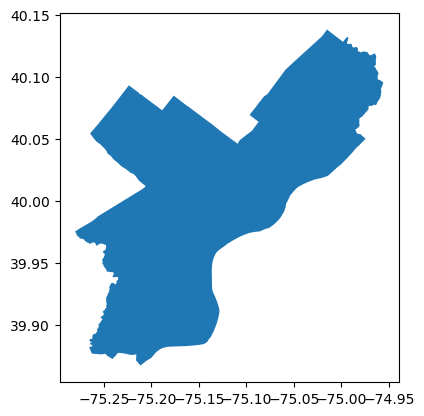

In [7]:
city_boundary = ox.geocode_to_gdf("Philadelphia, Pennsylvania, USA")

city_boundary.plot()

Trim bus network:

<Axes: >

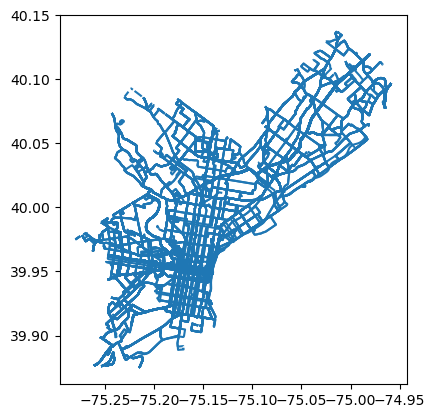

In [8]:
# Clip the shapes to the Philadelphia boundary
bus_network_philadelphia = gpd.clip(bus_network, city_boundary)

bus_network_philadelphia.plot()

At this step, we ensure that our segment data is working as desired so that it can combine with our points data.

In [9]:
from shapely.geometry import Point, LineString, MultiLineString

# Function to convert MultiLineString to LineString
def convert_to_linestring(geometry):
    if isinstance(geometry, MultiLineString):
        # Combine all components into a single LineString
        combined_coords = []
        for line in geometry.geoms:  # Use .geoms to iterate over the components
            combined_coords.extend(line.coords)
        return LineString(combined_coords)
    return geometry  # If already a LineString, return as is

# Apply the conversion function to the GeoDataFrame
bus_network_philadelphia['geometry'] = bus_network_philadelphia['geometry'].apply(convert_to_linestring)



<Axes: >

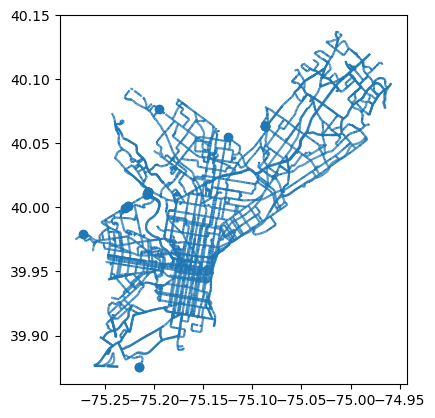

In [10]:
import networkx as nx
from shapely.ops import split, unary_union

# Create a graph from the GeoDataFrame
def geodataframe_to_graph(gdf):
    G = nx.Graph()
    for line in gdf.geometry:
        if isinstance(line, LineString):
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                G.add_edge(Point(coords[i]), Point(coords[i + 1]), geometry=LineString(coords[i:i + 2]))
    return G

# Convert GeoDataFrame to a graph
graph = geodataframe_to_graph(bus_network_philadelphia)

# Split the network into edges divided by nodes
edges = []
for edge in graph.edges(data=True):
    line = edge[2]['geometry']
    start_node = edge[0]
    end_node = edge[1]
    edges.append({
        'geometry': line,
        'start': start_node,
        'end': end_node
    })

# Create a GeoDataFrame of edges
edges_gdf = gpd.GeoDataFrame(edges, crs=bus_network_philadelphia.crs)

edges_gdf = gpd.clip(edges_gdf, city_boundary)

edges_gdf.plot()


### Total daily buses arriving at each bus stop:

By aggregating this data, we estimated the daily arrivals at each bus stop, effectively quantifying the daily traffic across the network. The distribution, as illustrated in the bar plot below, reveals that while a small number of stops experience exceptionally high traffic exceeding 2,000 buses per day (likely transit interchange hubs), the majority of bus stops accommodate approximately 183 buses daily.

In [11]:
daily_buses = stop_times_df.groupby(["stop_id"]).size().reset_index(name="daily_arrivals")

daily_buses_sorted = daily_buses.sort_values(by="daily_arrivals", ascending=False).reset_index(drop=True)

daily_buses_sorted.head()

,stop_id,daily_arrivals
0,283,3876
1,593,2592
2,21204,2323
3,10266,2252
4,1148,2219


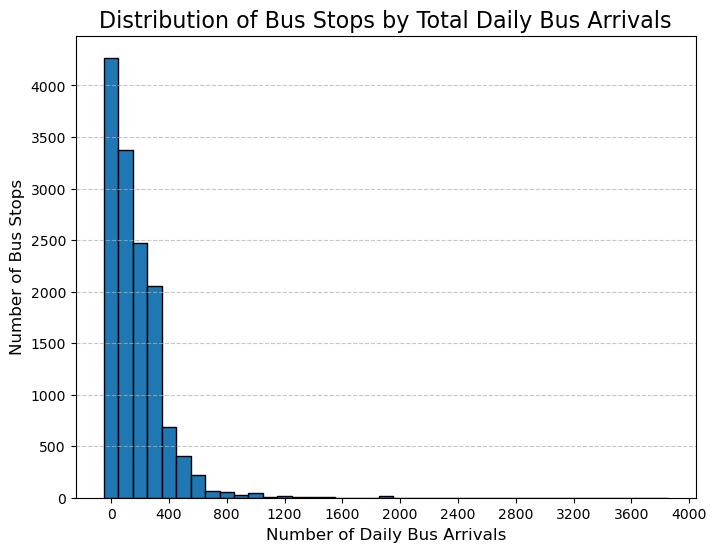

In [13]:
plt.figure(figsize=(8, 6))

# Create the histogram with bins in intervals of 400
plt.hist(
    daily_buses["daily_arrivals"],
    bins=range(0, daily_buses["daily_arrivals"].max() + 100, 100),  # Adjust bins
    edgecolor="black",
    align="left"
)

# Set titles and labels
plt.title("Distribution of Bus Stops by Total Daily Bus Arrivals", fontsize=16)
plt.xlabel("Number of Daily Bus Arrivals", fontsize=12)
plt.ylabel("Number of Bus Stops", fontsize=12)

# Set x-ticks to match the bin intervals
plt.xticks(range(0, daily_buses["daily_arrivals"].max() + 400, 400))

# Add a grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Display the plot
plt.show()

### Total Number and Peak Period

The data was subsequently grouped by each hour of the day to analyze the temporal distribution of bus service. The bar chart below illustrates the hourly distribution, revealing two distinct periods of heightened bus frequency: between 7 AM and 8 AM, and from 3 PM to 6 PM, with consistently elevated service levels during the midday hours. Bus frequency gradually declines after 8 PM until 5 AM. For the purpose of this analysis, the 3 PM to 6 PM window is designated as the peak period due to its sustained high frequency and significance in transit operations.

In [14]:
stop_times_df["hour"] = stop_times_df["arrival_time"].str.slice(0, 2).astype(int)

# Group by trip_id and hour, and count rows
hourly_bus_arrivals = stop_times_df.groupby(["stop_id", "hour"]).size().reset_index(name="hourly_arrivals")

hourly_bus_arrivals_sorted = hourly_bus_arrivals.sort_values(by="hourly_arrivals", ascending=False).reset_index(drop=True)

hourly_bus_arrivals_sorted.head()

,stop_id,hour,hourly_arrivals
0,283,16,287
1,283,17,278
2,283,8,273
3,283,15,266
4,283,7,232


### Find number of buses per hour on the entire system to determine peak period:

In [15]:
total_hourly_buses = stop_times_df.groupby(["hour"]).size().reset_index(name="total_bus_arrivals")

total_hourly_buses = total_hourly_buses[total_hourly_buses["hour"] <= 24]

total_hourly_buses = total_hourly_buses.sort_values(by="total_bus_arrivals", ascending=False).reset_index(drop=True)

total_hourly_buses.head()

,hour,total_bus_arrivals
0,16,188679
1,15,187335
2,17,184023
3,7,177282
4,8,176510


### Find Peak Period

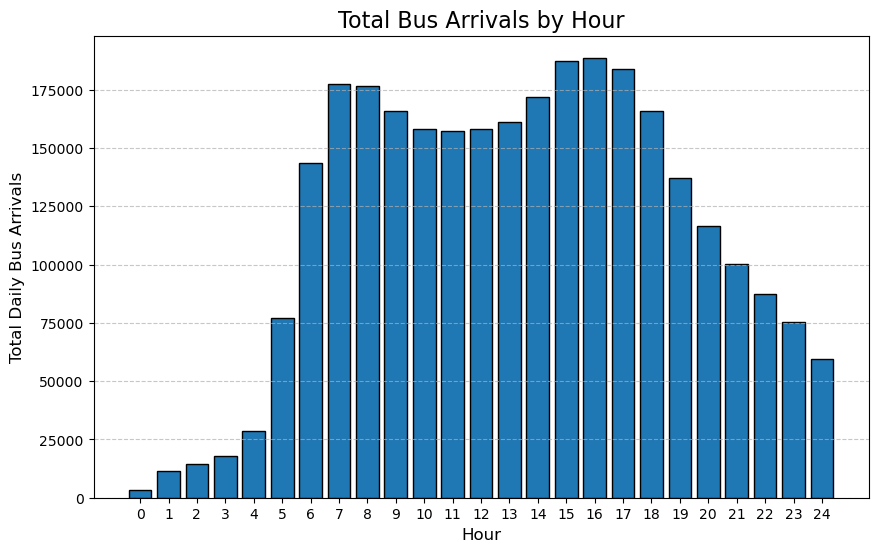

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(total_hourly_buses["hour"], total_hourly_buses["total_bus_arrivals"], edgecolor="black")

# Add labels and title
plt.title("Total Bus Arrivals by Hour", fontsize=16)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Total Daily Bus Arrivals", fontsize=12)
plt.xticks(total_hourly_buses["hour"])  # Ensure x-axis ticks align with hours
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

### Bus Frequency

In transit planning, frequency refers to the number of buses servicing a particular stop within a given time frame, typically measured as buses per hour. It is a critical metric for understanding the level of service provided by a transit network, as higher frequency generally translates to shorter wait times for passengers and improved overall service reliability. In this analysis, frequency is calculated by determining the number of bus arrivals at each stop during specified time periods (3 PM to 6 PM).

In [17]:
peak_bus_arrivals = hourly_bus_arrivals[hourly_bus_arrivals["hour"].isin([3, 4, 5])]

peak_frequency = peak_bus_arrivals.groupby("stop_id", as_index=False)["hourly_arrivals"].sum()

peak_frequency = peak_frequency.rename(columns={"hourly_arrivals": "bus_arrivals"})

# Create a new column 'frequency'
peak_frequency["frequency"] = peak_frequency["bus_arrivals"] / 3

peak_frequency.head()

,stop_id,bus_arrivals,frequency
0,2,23,7.666667
1,4,46,15.333333
2,5,37,12.333333
3,7,6,2.000000
4,8,66,22.000000


Note: Frequency is the number of buses per hour at a bus stop

### Bus Headways

Additionally, headways—the time interval between consecutive buses at a stop—are directly derived from frequency. It directly impacts passenger experience, as shorter headways result in reduced waiting times and greater convenience, particularly during peak periods when demand is highest. Here, we first calculate the number of bus arrivals at a stop during peak period. After getting the per hour frequency, we calculate the headway at a bus stop by dividing 60 minutes. On an average the headway is 30 minutes.

In [18]:
# Calculate the headway and assign it to a new column
peak_frequency["headway"] = 60 / peak_frequency["frequency"]

peak_frequency = peak_frequency.sort_values(by="headway", ascending=True).reset_index(drop=True)

# Display the updated DataFrame
print(peak_frequency)

      stop_id  bus_arrivals  frequency     headway
0       10266           231  77.000000    0.779221
1         283           194  64.666667    0.927835
2        1148           176  58.666667    1.022727
3       31564           166  55.333333    1.084337
4         341           111  37.000000    1.621622
...       ...           ...        ...         ...
9981    27732             1   0.333333  180.000000
9982    22380             1   0.333333  180.000000
9983    22370             1   0.333333  180.000000
9984    22388             1   0.333333  180.000000
9985    18183             1   0.333333  180.000000

[9986 rows x 4 columns]


Note: Headway refers to number of minutes in between bus arrivals

### Merge calculated bus metrics with the stops dataframe containing stop names and co-ordinates:

In [19]:
peak_metrics = pd.merge(peak_frequency, stops_df, on="stop_id", how="inner")

peak_metrics.head()

,stop_id,bus_arrivals,frequency,headway,stop_name,stop_lat,stop_lon,location_type,parent_station,zone_id,wheelchair_boarding
0,10266,231,77.000000,0.779221,Market St & 15th St,39.952547,-75.165475,NaN,NaN,1,1
1,283,194,64.666667,0.927835,13th St,39.952532,-75.162559,NaN,NaN,1,2
2,1148,176,58.666667,1.022727,69th St Transportation Center South Terminal,39.962079,-75.258284,NaN,31034.0,1,1
3,31564,166,55.333333,1.084337,15th St & Market St - FS,39.952493,-75.165393,NaN,NaN,1,1
4,341,111,37.000000,1.621622,Richmond St & Westmoreland St Loop,39.984253,-75.099553,NaN,NaN,1,1


### Bus Ridership:

We then merge the ridership at each stop to our existing dataset containing frequency and headway.

In [20]:
ridership = pd.read_csv("Data/Fall_2023_Stop_Summary_(Bus).csv")

ridership["Ridership"] = ridership["Weekday_On"] + ridership["Weekday_Of"]

ridership.rename(columns={"Stop_Code": "stop_id"}, inplace=True)

ridership_by_stop = ridership.groupby("stop_id")["Ridership"].sum().reset_index()

ridership_by_stop.head()

,stop_id,Ridership
0,2,1188
1,4,666
2,5,448
3,7,41
4,8,1280


In [21]:
#Merge Ridership and Schedules

peak_metrics = pd.merge(peak_metrics, ridership_by_stop, on="stop_id", how="inner")

print(peak_metrics)

      stop_id  bus_arrivals  frequency     headway  \
0       10266           231  77.000000    0.779221   
1        1148           176  58.666667    1.022727   
2       31564           166  55.333333    1.084337   
3         341           111  37.000000    1.621622   
4         841           103  34.333333    1.747573   
...       ...           ...        ...         ...   
9140    27732             1   0.333333  180.000000   
9141    22380             1   0.333333  180.000000   
9142    22370             1   0.333333  180.000000   
9143    22388             1   0.333333  180.000000   
9144    18183             1   0.333333  180.000000   

                                         stop_name   stop_lat   stop_lon  \
0                              Market St & 15th St  39.952547 -75.165475   
1     69th St Transportation Center South Terminal  39.962079 -75.258284   
2                         15th St & Market St - FS  39.952493 -75.165393   
3               Richmond St & Westmoreland St L

Our analysis aimed to determine whether higher frequency (or shorter headways) correlates with greater ridership. While ridership and frequency exhibit a positive correlation, the presence of many outliers highlights the need for a combined analysis of both variables. This is crucial for identifying streets that would benefit most from improvements such as bus lanes, and it suggests that increasing frequency may be necessary to better accommodate the current ridership levels.

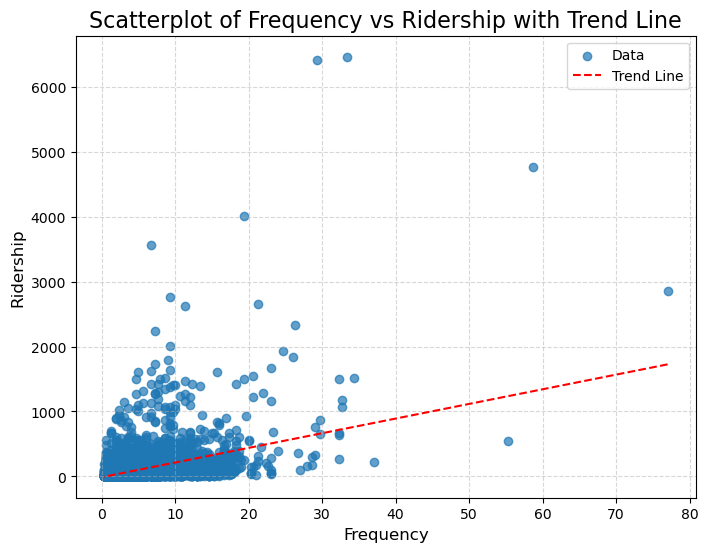

In [22]:
import numpy as np

# Ensure data is numeric and drop rows with NaN values for the columns of interest
peak_metrics_cleaned = peak_metrics.dropna(subset=['frequency', 'Ridership'])

# Extract the data
x = peak_metrics_cleaned['frequency']
y = peak_metrics_cleaned['Ridership']

# Fit a linear regression model
coefficients = np.polyfit(x, y, 1)  # Degree 1 for linear regression
trendline = np.poly1d(coefficients)

# Create the scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7, label='Data')

# Add the trend line
plt.plot(x, trendline(x), color='red', linestyle='--', label='Trend Line')

# Add titles and labels
plt.title('Scatterplot of Frequency vs Ridership with Trend Line', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Ridership', fontsize=12)

# Add legend
plt.legend()

# Show grid
plt.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

This presumption is supported by the scatter-plot below, which reveals that stops with extremely high ridership are concentrated near the origin, corresponding to headways of under 25 minutes. We can also see that areas with greater headways have their ridership closer to origin well- suggesting lower ridership demand.

In [ ]:
# Scatterplot: Ridership vs. Headway
plt.figure(figsize=(8, 6))

plt.scatter(
    peak_metrics["headway"],
    peak_metrics["Ridership"],
    c="blue",
    alpha=0.4,)

plt.title("Scatterplot: Ridership vs. Headway", fontsize=16)
plt.xlabel("Headway (minutes)", fontsize=12)
plt.ylabel("Ridership", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Convert Bus Data to GeoDataframe

In [23]:
geometry = [Point(xy) for xy in zip(peak_metrics["stop_lon"], peak_metrics["stop_lat"])]
peak_metrics_geo = gpd.GeoDataFrame(peak_metrics, geometry=geometry)

# Set a Coordinate Reference System (CRS)
peak_metrics_geo.set_crs(epsg=4326, inplace=True)  # WGS84 CRS

peak_metrics_geo.head()

,stop_id,bus_arrivals,frequency,headway,stop_name,stop_lat,stop_lon,location_type,parent_station,zone_id,wheelchair_boarding,Ridership,geometry
0,10266,231,77.000000,0.779221,Market St & 15th St,39.952547,-75.165475,NaN,NaN,1,1,2848,POINT (-75.16548 39.95255)
1,1148,176,58.666667,1.022727,69th St Transportation Center South Terminal,39.962079,-75.258284,NaN,31034.0,1,1,4758,POINT (-75.25828 39.96208)
2,31564,166,55.333333,1.084337,15th St & Market St - FS,39.952493,-75.165393,NaN,NaN,1,1,539,POINT (-75.16539 39.95249)
3,341,111,37.000000,1.621622,Richmond St & Westmoreland St Loop,39.984253,-75.099553,NaN,NaN,1,1,222,POINT (-75.09955 39.98425)
4,841,103,34.333333,1.747573,Fern Rock Transportation Center,40.041940,-75.136970,NaN,NaN,1,1,1509,POINT (-75.13697 40.04194)


<Axes: >

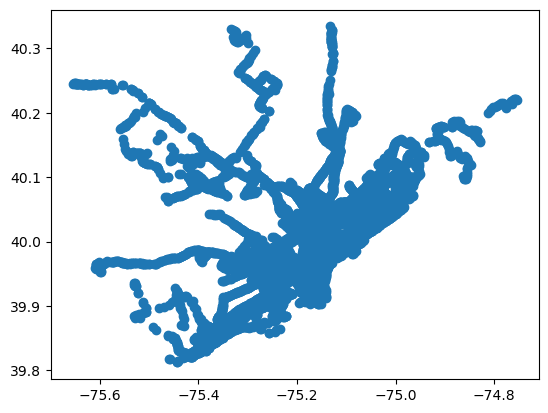

In [24]:
peak_metrics_geo.plot()

To focus on bus stops within the city limits, we restrict the data to those located inside the city boundary:

In [25]:
peak_metrics_geo = gpd.clip(peak_metrics_geo, city_boundary)

<Axes: >

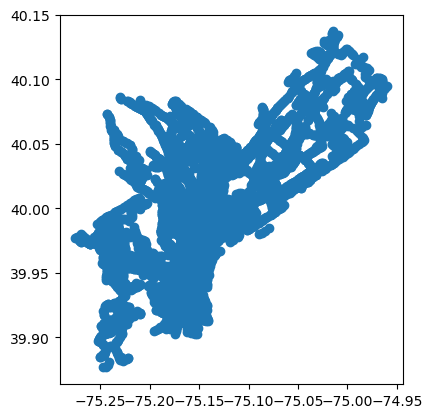

In [26]:
peak_metrics_geo.plot()

## Level of Service Analysis

To better understand the spatial distribution of bus network, we first clipped the network to city limits.

## Visualise metrics by bus stop:

To evaluate the level of service across Philadelphia and understand user patterns, we visualized three key components—frequency, headway, and ridership—on a map for peak periods. The map reveals that most areas in the city benefit from frequent bus services, with frequency under 10 during peak times and averaging below 20 minutes headway across the day. However, there are extreme outliers in some regions, where headway exceed 180 minutes, highlighting disparities in service provision. By adding a geographic component, we observe a more nuanced distribution of ridership across Philadelphia. As expected, areas in Center City exhibit high ridership and frequent bus service. Conversely, far-flung areas such as Upper Northwest and Lower Northwest show lower ridership levels and greater headway. Interestingly, Lower Northeast stands out with the highest ridership of all districts.

Interestingly, while frequency and headway vary significantly across the city, ridership appears more evenly distributed, with notable exceptions in Center City, which experiences concentrated high ridership, and the Lower Northwest, near Mt. Airy, which shows higher ridership despite longer headway.

In [1]:
import ipywidgets as widgets

# create function
def create_map(selected_metric):
    fig, ax = plt.subplots(figsize=(8, 8))
    peak_metrics_geo.plot(
        ax=ax,
        column=selected_metric, 
        cmap="plasma",            
        legend=True,              
        markersize=2)
    
    
    plt.title(f"{selected_metric.capitalize()} by Bus Stop", fontsize=16)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

dropdown = widgets.Dropdown(
    options=['frequency', 'headway', 'Ridership'],  
    value='frequency',
    description='Metric:',)

widgets.interactive(create_map, selected_metric=dropdown)

NameError: name 'plt' is not defined

interactive(children=(Dropdown(description='Metric:', options=('frequency', 'headway', 'Ridership'), value='fr…

# Join Bus Stop Level Metrics to Philadelphia's Bus Network:

Spatial Join: Bus Stops to Bus Network

Till now we were looking at transit data at a point, however to understand what routes generate the most traffic and what routes to prioritze, we need to look at the data at street level. To achieve this, we joined the bus stops to the bus network, ensuring that each point is associated with the nearest street segment.

In [30]:
# Ensure both GeoDataFrames are in a projected CRS

peak_metrics_geo = peak_metrics_geo.to_crs("EPSG: 2272")
edges_gdf = edges_gdf.to_crs("EPSG: 2272")

peak_metrics_geo = peak_metrics_geo.reset_index(drop=True)

# Perform a spatial join to find the nearest road segment
peak_metrics_network = gpd.sjoin_nearest(
    edges_gdf,                     # GeoDataFrame with road segments
    peak_metrics_geo,  # GeoDataFrame with bus stop points
    how="left",                # Keep all bus stops even if no match
    distance_col="distance"    # Adds a column with the distance to the nearest road segment
)

#Re-project to a geographic CRS
peak_metrics_network = peak_metrics_network.to_crs("EPSG: 4326")

peak_metrics_network.head()

,geometry,start,end,index_right,stop_id,bus_arrivals,frequency,headway,stop_name,stop_lat,stop_lon,location_type,parent_station,zone_id,wheelchair_boarding,Ridership,distance
292,"LINESTRING (-75.25350 39.87616, -75.25399 39.8...",POINT (-75.253495 39.876162),POINT (-75.25398839928764 39.87604214946382),0.0,17103.0,55.0,18.333333,3.272727,Philadelphia Airport Terminal A,39.876761,-75.247175,NaN,30615.0,1.0,1.0,314.0,1787.205503
291,"LINESTRING (-75.25327 39.87622, -75.25350 39.8...",POINT (-75.25327 39.876224),POINT (-75.253495 39.876162),0.0,17103.0,55.0,18.333333,3.272727,Philadelphia Airport Terminal A,39.876761,-75.247175,NaN,30615.0,1.0,1.0,314.0,1721.831860
290,"LINESTRING (-75.25312 39.87627, -75.25327 39.8...",POINT (-75.253117 39.87627),POINT (-75.25327 39.876224),0.0,17103.0,55.0,18.333333,3.272727,Philadelphia Airport Terminal A,39.876761,-75.247175,NaN,30615.0,1.0,1.0,314.0,1677.304469
157,"LINESTRING (-75.25003 39.87626, -75.25003 39.8...",POINT (-75.2500277483444 39.87625617880794),POINT (-75.250026 39.876257),0.0,17103.0,55.0,18.333333,3.272727,Philadelphia Airport Terminal A,39.876761,-75.247175,NaN,30615.0,1.0,1.0,314.0,820.984358
293,"MULTILINESTRING ((-75.25399 39.87604, -75.2539...",POINT (-75.25398839928764 39.87604214946382),POINT (-75.26120568475493 39.8764816048662),0.0,17103.0,55.0,18.333333,3.272727,Philadelphia Airport Terminal A,39.876761,-75.247175,NaN,30615.0,1.0,1.0,314.0,1930.164592


## Visualisation of Metrics by Street Segments on Philadelphia's Bus Network

Following the spatial join, we can now analyze bus headways during peak hours by street segments, providing a more refined view of service levels across different parts of the city. Major corridors in Philadelphia, such as Broad Street, Walnut Street, Chestnut Street, Market Street, and Roosevelt Boulevard, exhibit headways of under 20 minutes, reflecting frequent service. In contrast, streets on the city's periphery have significantly longer headways, exceeding 120 minutes, highlighting areas with less frequent service.

Text(110.89550110614813, 0.5, 'Latitude')

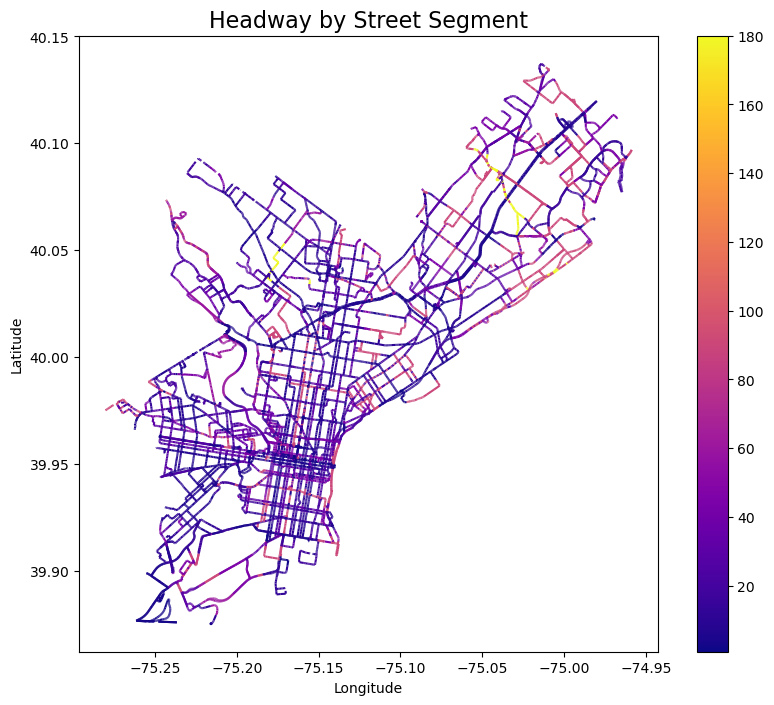

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
peak_metrics_network.plot(
    ax=ax,
    column="headway",  # Color by buses_count
    cmap="plasma",        # Use a colormap (e.g., viridis, plasma, etc.)
    legend=True,           # Add a legend
    markersize=1         # Adjust marker size
)

# Add titles and labels
plt.title("Headway by Street Segment", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

When examining ridership by street segments, the distribution tells a different story. Ridership remains relatively consistent across most of the network, regardless of the headway. However, ridership spikes above 2,000 passengers for specific routes around Mt. Airy, Frankford, N Broad St., as well as Center City. These areas, particularly in the North, host major transportation hubs that attract a high volume of trips.

Text(110.89550110614813, 0.5, 'Latitude')

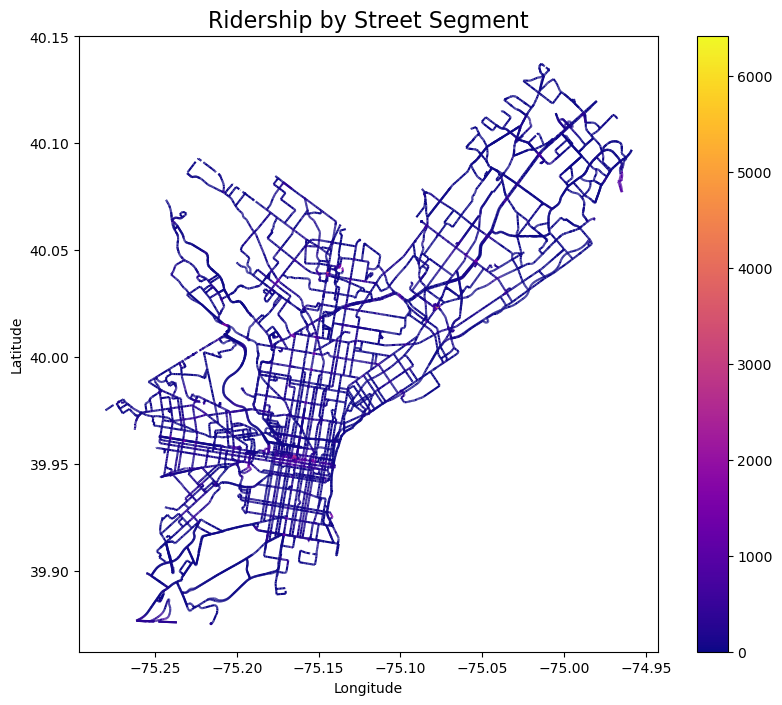

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))
peak_metrics_network.plot(
    ax=ax,
    column="Ridership",  # Color by buses_count
    cmap="plasma",        # Use a colormap (e.g., viridis, plasma, etc.)
    legend=True,           # Add a legend
    markersize=1         # Adjust marker size
)

# Add titles and labels
plt.title("Ridership by Street Segment", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [33]:
peak_metrics_network = peak_metrics_network.drop(columns=['start', 'end'], errors='ignore')  # Replace 'start', 'end' with problematic columns

peak_metrics_network.to_file("Data/peak_metrics_network.geojson", driver="GeoJSON")